# Initialization cell

In [2]:
! pip install --upgrade pip
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn
! pip install joblib
! pip install --upgrade termcolor
! pip install cloudpickle

In [3]:
import pandas as pd
import numpy as np

import gdown
import os
import json

import matplotlib.pyplot as plt

from dataclasses import dataclass, fields, asdict

from typing import List, Optional, Tuple, Dict
import shutil
from dotenv import load_dotenv

import joblib
import cloudpickle
from termcolor import colored

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to /home/kitsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kitsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparation cell

In [4]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_V2_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None: SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')

In [5]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')

        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data


def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [6]:
skills_dict = get_skill_dict()

In [7]:
df_original = get_original_dataframe()

Success!


In [8]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
76145,94232531,Backend,TeamLead backend разработки (Clojure),2024-03-04T21:47:43+0300,2024-03-04T21:47:43+0300,2024-03-24 19:26:33.262,https://api.hh.ru/vacancies/94232531?host=hh.ru,Москва,NaN,NaN,...,NaN,Удаленная работа,Senior (>6),Полная занятость,"['Clojure', 'Grafana', 'Clickhouse']",[],NaN,NaN,NaN,NaN
127163,97130600,Project manager,Руководитель проектов,2024-04-16T15:12:38+0300,2024-04-16T15:12:38+0300,2024-04-17 10:50:23.602,https://api.hh.ru/vacancies/97130600?host=hh.ru,Санкт-Петербург,NaN,NaN,...,NaN,Полный день,Junior (1-3),Полная занятость,"['Организаторские навыки', 'Проектный менеджме...",[],NaN,NaN,NaN,NaN
343,91067394,QA инженер,Менеджер по качеству / Инженер по качеству,2024-01-23T08:20:25+0300,2024-01-23T08:20:25+0300,2024-01-24 00:00:00.000,https://api.hh.ru/vacancies/91067394?host=hh.ru,Санкт-Петербург,RUR,0.0,...,Санкт-Петербург,Полный день,Intern (0-1),Полная занятость,"['Внутренний аудит', 'Разработка и внедрение п...",[],1.0,62150.0,NaN,NaN


# Function & utils cell

In [9]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())

In [10]:
class ClearDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, save_cols: Optional[List[str]] = None) -> None:
        self.save_cols = save_cols

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ClearDataFrameTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X[self.save_cols].copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
        df_new = df_new.dropna(subset=['income__name'])
        df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)
        return df_new


class RenameDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'RenameDataTransformer':
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        return df_new


class CreateNewCitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: int = 75):
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CreateNewCitiesTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        cities = df_new['area__name'].unique()
        city_counts = df_new['area__name'].value_counts()
        N_rows = df_new.shape[0]
        ratios = {city: city_counts[city] / N_rows for city in cities}

        answer = []
        all_percentage = 0
        sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
        for label, pct in sorted_dict.items():
            all_percentage += pct * 100
            if all_percentage < self.threshold:
                answer.append(label)

        df_new.loc[~df_new['area__name'].isin(answer), 'area__name'] = 'Малый город'
        return df_new
    
    
class SelectProfessionsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prof_list: Optional[List[str]] = None, whitelist: bool = True) -> None:
        self.prof_list = prof_list
        self.whitelist = whitelist

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'SelectProfessionsTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        if self.whitelist:
            df_new = df_new[df_new['income__name'].isin(self.prof_list)]
        else:
            df_new = df_new[~df_new['income__name'].isin(self.prof_list)]
        return df_new


class FillNaSalaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, coef_index: int) -> None:
        self.coef_index = coef_index
    
    @staticmethod
    def get_difference_percentiles(df: pd.DataFrame) -> Tuple[float, float, float]:
        filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
        filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
        condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
        filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

        filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

        filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
        filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

        filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0,
                                                        filtered_df['difference'] / filtered_df['salary_to_gross'],
                                                        np.nan)

        perc25 = filtered_df['difference_ratio'].quantile(0.25)
        perc50 = filtered_df['difference_ratio'].quantile(0.50)
        perc75 = filtered_df['difference_ratio'].quantile(0.75)

        return perc25, perc50, perc75

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'FillNaSalaryTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        coef = self.get_difference_percentiles(df_new)[self.coef_index]
        df_new['salary_to_gross'] = df_new['salary_to_gross'].fillna(df_new['salary_from_gross'] / (1 - coef))
        df_new['salary_from_gross'] = df_new['salary_from_gross'].fillna(df_new['salary_to_gross'] * (1 - coef))
        df_new['salary_average'] = df_new['salary_average'].fillna((df_new['salary_to_gross'] + df_new['salary_from_gross']) / 2)

        df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']] = df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
        return df_new
    

class PreprocessKeySkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, s_dict: Dict[str, List[str]], 
                 with_skills: bool = True, 
                 with_grade: bool = True, 
                 with_area: bool = True) -> None:
        
        self.s_dict = s_dict
        self.with_skills = with_skills
        self.with_grade = with_grade
        self.with_area = with_area

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'PreprocessKeySkillsTransformer':
        return self
    
    @staticmethod
    def convert_skills(skill_string: str, skills_dict: Dict[str, List[str]]) -> Tuple[List[str], List[str]]:
        skill_list = eval(skill_string)
        converted_skills = []
        unconverted_skills = []
        for skill in skill_list:
            found = False
            for main_skill, variations in skills_dict.items():
                if skill in variations:
                    converted_skills.append(main_skill)
                    found = True
                    break
            if not found:
                unconverted_skills.append(skill)

        return converted_skills, unconverted_skills

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()

        if self.with_skills:
            df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
                lambda x: pd.Series(self.convert_skills(x, self.s_dict))
            )

        df_new = df_new.drop(['key_skills__names'], axis=1)

        if not self.with_grade:
            df_new = df_new.drop(columns=df_new.filter(like='grade').columns, axis=1)

        if not self.with_area:
            df_new = df_new.drop(columns=df_new.filter(like='area_name').columns, axis=1)

        return df_new
    

class ProcessSkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, freq_cutoff: int = 100, 
                       add_unprocessed: bool = False) -> None:
        self.freq_cutoff = freq_cutoff
        self.add_unprocessed = add_unprocessed

        self.morph = pymorphy2.MorphAnalyzer()
        self.nltk_stop_words = set(stopwords.words('russian'))
        self.custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык',
                             'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
        self.stop_words = self.nltk_stop_words.union(self.custom_words)

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ProcessSkillsTransformer':
        return self

    def tokenize_and_lemmatize(self, skill_list: List[str]) -> List[str]:
        tokens = []
        for skill in skill_list:
            words = word_tokenize(skill)
            lemmas = [self.morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in self.stop_words]
            tokens.extend(lemmas)
        return tokens

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_processed = X.copy()

        def prepare_skills(df: pd.DataFrame, col: str) -> pd.DataFrame:
            df_new = df.copy()
            df_new[col] = df_new[col].apply(self.tokenize_and_lemmatize)
            counts = df_new[col].explode().value_counts()
            frequent = counts[counts >= self.freq_cutoff].index
            df_new[col] = df_new[col].apply(lambda skills: [skill for skill in skills if skill in frequent])
            return df_new

        if self.add_unprocessed:
            df_processed = prepare_skills(df_processed, 'skills')
            df_processed = prepare_skills(df_processed, 'unconverted_skills')
            df_processed['skills_plus'] = df_processed['skills'] + df_processed['unconverted_skills']
        else:
            df_processed['skills_plus'] = df_processed['skills']

        df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]
        df_processed = df_processed.drop(['unconverted_skills', 'skills'], axis=1)
        return df_processed


class VectorizePCASkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 n_components: int = 100, 
                 PCA_enable: bool = True, 
                 add_unprocessed: bool = False) -> None:
        
        self.n_components = n_components
        self.PCA_enable = PCA_enable
        self.add_unprocessed = add_unprocessed
        
        if not self.add_unprocessed:
            self.vectorizer = TfidfVectorizer(analyzer=lambda x: x)
        else:
            self.vectorizer = TfidfVectorizer()

        self.pca = PCA(n_components=self.n_components)

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'VectorizePCASkillsTransformer':
        X = X.copy()
        if self.add_unprocessed:
            X['skills_plus'] = X['skills_plus'].apply(lambda x: ' '.join(x))

        self.vectorizer.fit(X['skills_plus'])
        if self.PCA_enable:
            skills_tfidf = self.vectorizer.transform(X['skills_plus'])
            skills_df = pd.DataFrame(skills_tfidf.toarray(), 
                                     columns=self.vectorizer.get_feature_names_out())
            self.pca.fit(skills_df)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_vect = X.copy()

        skills_tfidf = self.vectorizer.transform(df_vect['skills_plus'])
        skills_df = pd.DataFrame(skills_tfidf.toarray(), 
                                 columns=self.vectorizer.get_feature_names_out())
        df_vect = df_vect.reset_index()

        if self.PCA_enable:
            skills_pca = self.pca.transform(skills_df)
            skills_pca_df = pd.DataFrame(skills_pca, 
                                         columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])
            df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
        else:
            df_merged = pd.concat([df_vect, skills_df], axis=1)

        df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)

        return df_merged


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_param: Optional[str] = None) -> None:
        self.drop_param = drop_param
        self.transformers = [
            ('schedule_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['schedule__name']),
            ('grade', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['grade']),
            ('income_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['income__name']),
            ('area_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['area__name'])
        ]
        self.pipeline = Pipeline(steps=[
            ('column_transformer', ColumnTransformer(transformers=self.transformers, remainder='passthrough'))
        ])

    def fit(self, X: pd.DataFrame, y=None) -> 'ExtractFeaturesTransformer':
        self.pipeline.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new = self.pipeline.transform(df_new)
        
        column_names = self.pipeline.named_steps['column_transformer'].get_feature_names_out()
        strings_to_replace = ['remainder__','schedule__name_','income__name_', 'area__name_']
        for string in strings_to_replace:
            column_names = [x.replace(string, '') for x in column_names]
        column_names = [x.replace('grade__grade_', 'grade_') for x in column_names]
        
        df_new = pd.DataFrame(df_new, columns=column_names)

        return df_new


class ConvertTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, new_type: type) -> None:
        self.new_type = new_type

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ConvertTypeTransformer':
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new: pd.DataFrame = df_new.astype(self.new_type)
        return df_new
    

# Preprocessing Pipleline

In [11]:
RANDOM_STATE = 42

income_names_IT = ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile',
                   'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst',
                   'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик',
                   'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']

income_names_1C = ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С',
                   '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']

income_names_other = ['Менеджер по продажам', 'Менеджер по работе с клиентами',
                      'Специалист технической поддержки']

SAVE_COLS = ['income_name', 'area__name', 'schedule__name', 'grade',
            'key_skills__names', 'salary__currency',
            'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average']


@dataclass
class PreprocessParams:
    BASIC_TRANSFORM: bool = False
    FREQ_CUTOFF: int = 1000
    DROP_PARAM_ONE_HOT = 'first'
    THRESHOLD_CITIES: int = 50
    PERC_NUMBER: int = 0  # 0 - 25% | 1 - 50% | 2 - 75%
    IS_PCA_ENABLE: bool = True
    N_COMPONENTS: int = 100
    ADD_UNPROCESSED: bool = False
    WITH_SKILLS: bool = True
    WITH_GRADE: bool = True
    WITH_AREA: bool = True
    WHITELIST: bool = True
    PROF_LIST: list = None
    VERBOSE: bool = False

    def __repr__(self):
        field_strings = []
        for field in fields(self):
            field_name = field.name
            field_value = getattr(self, field_name)
            field_strings.append(f"* {field_name}: {field_value}")
        result_str = "\n".join(field_strings)
        sep = colored('\n' + '-' * 30 + '\n', 'cyan')
        return f'\nPreprocess params:{sep}{result_str}'

def get_preprocess_pipeline(params: PreprocessParams) -> Pipeline:
    basic_pipe = Pipeline(steps=[
            ('clear_df', ClearDataFrameTransformer(SAVE_COLS)),
            ('create_new_cities', CreateNewCitiesTransformer(params.THRESHOLD_CITIES)),
            ('select_professions', SelectProfessionsTransformer(params.PROF_LIST, params.WHITELIST)),
            ('fill_na_salary', FillNaSalaryTransformer(params.PERC_NUMBER)),
            ('preprocess_key_skills', PreprocessKeySkillsTransformer(skills_dict,
                                                                     params.WITH_SKILLS,
                                                                     params.WITH_GRADE,
                                                                     params.WITH_AREA))
        ], verbose=params.VERBOSE)

    if params.BASIC_TRANSFORM:
        display(basic_pipe)
        return basic_pipe

    pipe_skill_vectorize = Pipeline(steps=[
            ('process_skills', ProcessSkillsTransformer(params.FREQ_CUTOFF,
                                                        params.ADD_UNPROCESSED)),
            ('vectorize_PCA_skills', VectorizePCASkillsTransformer(params.N_COMPONENTS,
                                                                params.IS_PCA_ENABLE,
                                                                params.ADD_UNPROCESSED))
        ],verbose=params.VERBOSE)

    if params.WITH_SKILLS:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT)),
            ('skill_vectorize', pipe_skill_vectorize),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)
    else:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT)),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)

    print(params, end='\n\n')
    display(pipe)
    return pipe

In [37]:
df_all = get_preprocess_pipeline(PreprocessParams(PROF_LIST=['Frontend'],
                                                  WHITELIST=False,
                                                  IS_PCA_ENABLE=False)).fit_transform(df_original)
print_df_info(df_all)


Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: False
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: False
* PROF_LIST: ['Frontend']
* VERBOSE: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer(PCA_enable=False))])),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

Shape: (49178, 471)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,финансовый контроль,функциональное тестирование,художественный вкус,ценообразование,чувство вкуса,чувство стиля,эконометрика,экономика,экономический анализ,эксплуатационные документы
26201,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28804,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26815,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49178 entries, 0 to 49177
Columns: 471 entries, schedule_name__Гибкий график to эксплуатационные документы
dtypes: float64(471)
memory usage: 176.7 MB


None

In [12]:
preprocess_params = {
    "IT": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        IS_PCA_ENABLE=False,
        PROF_LIST=income_names_IT
    ),
    "1C": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_1C
    ),
    "other": PreprocessParams(
        WITH_SKILLS=False,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_other
    )
}

results = {}

width = 40

for key, params in preprocess_params.items():
    print(colored(f"{key:-^{width}}", 'green'))
    pipeline = get_preprocess_pipeline(params).fit(df_original)
    df_processed = pipeline.transform(df_original)
    results[key] = {
        "data": df_processed,
        "pipe": pipeline,
        "Params": params,
        "pretrained_model": None,
        "rmse_score": None
    }

df_after_preprocess_IT = results["IT"]["data"]
df_after_preprocess_1C = results["1C"]["data"]
df_after_preprocess_other = results["other"]["data"]

-------------------IT-------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: False
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile', 'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst', 'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик', 'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']
* VERBOSE: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer(PCA_enable=False))])),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

-------------------1C-------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С', '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']
* VERBOSE: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer())])),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

-----------------other------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: False
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Менеджер по продажам', 'Менеджер по работе с клиентами', 'Специалист технической поддержки']
* VERBOSE: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                             'LIGHTROOM',
                                                                                             'adobe '
                                                                                             'lightroom',
                                                                                             'Adobe '
                                                                                             'lightroom'],
                                                                         'adobe photoshop': ['adobe '
                                                                                             'photoshop',
                                                                                             'ADOBE '
                                                                                             'PHOTOSHOP',
                                                                                             'Adobe '
                                                                                             'photoshop'],
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...},
                                                                 with_skills=False))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

In [13]:
print_df_info(df_after_preprocess_IT)

# print_df_info(df_after_preprocess_1C)

# print_df_info(df_after_preprocess_other)

Shape: (14708, 460)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Data Analyst,income_name__Data Engineer,income_name__Data Scientist,...,финансовый контроль,функциональное тестирование,художественный вкус,ценообразование,чувство вкуса,чувство стиля,эконометрика,экономика,экономический анализ,эксплуатационные документы
14504,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4614,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5086,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14708 entries, 0 to 14707
Columns: 460 entries, schedule_name__Гибкий график to эксплуатационные документы
dtypes: float64(460)
memory usage: 51.6 MB


None

# Deep Learning Solution

cuda
Epoch [1/200], Loss: 38901.3532, Val Loss: 23913.7270
Epoch [2/200], Loss: 23859.0997, Val Loss: 21398.2653
Epoch [3/200], Loss: 22341.5430, Val Loss: 20683.7940
Epoch [4/200], Loss: 21862.9544, Val Loss: 20414.7326
Epoch [5/200], Loss: 21652.7713, Val Loss: 20377.6275
Epoch [6/200], Loss: 21491.0727, Val Loss: 20433.5976
Epoch [7/200], Loss: 21435.4240, Val Loss: 20263.8062
Epoch [8/200], Loss: 21243.0503, Val Loss: 20245.5350
Epoch [9/200], Loss: 21240.5198, Val Loss: 20235.2388
Epoch [10/200], Loss: 21210.0812, Val Loss: 20143.6870
Epoch [11/200], Loss: 21074.9307, Val Loss: 20151.3736
Epoch [12/200], Loss: 21031.5330, Val Loss: 20171.1748
Epoch [13/200], Loss: 20938.7599, Val Loss: 20090.6959
Epoch [14/200], Loss: 20988.7270, Val Loss: 20232.2967
Epoch [15/200], Loss: 20889.2181, Val Loss: 20066.0662
Epoch [16/200], Loss: 20964.2955, Val Loss: 19982.8824
Epoch [17/200], Loss: 20815.4846, Val Loss: 19930.8824
Epoch [18/200], Loss: 20760.5228, Val Loss: 20047.2593
Epoch [19/200]

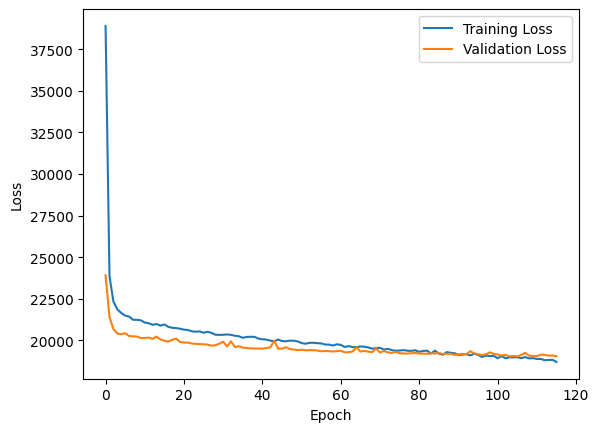

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

data = df_all.copy()

X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average']).values 
y = data['salary_average'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class SparseRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(SparseRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x.to_dense()))  # Convert sparse to dense
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

model = SparseRegressionModel(X.shape[1]).to(device)

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

criterion = l1_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 200
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0
train_history = []
val_history = []

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_history.append(epoch_loss)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_history.append(val_epoch_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
    
    scheduler.step(val_epoch_loss)
    
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break


model.load_state_dict(torch.load('best_model.pth'))

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    l1_lose = l1_loss(y_pred, y_test).item()
    mse = mse_loss(y_pred, y_test).item()
    rmse = np.sqrt(mse)
    mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item() * 100

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.2f}%')

plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Fitting Model

In [94]:
param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE,
                                            criterion='friedman_mse')]
        }
]

mape = make_scorer(mean_absolute_percentage_error)
rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

def pipeline_train(data):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])
    y = data['salary_average']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

    best_models = {}

    for model_params in tqdm(param_grid):
        pipeline = Pipeline(steps=[
            ('model', model_params['model'])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, scoring=mape)
        display(grid_search)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)

        best_models[type(model_params['model']).__name__] = grid_search.best_estimator_
        print(f"Best parameters for {type(model_params['model']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {type(model_params['model']).__name__}: {grid_search.best_score_}")

    return best_models

In [86]:
# results_IT = pipeline_train(df_after_preprocess_IT)
# results_1C = pipeline_train(df_after_preprocess_1C)
# results_other = pipeline_train(df_after_preprocess_other)

In [239]:
def train(data, estimator, n_top_features=10):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    rmse_score = root_mean_squared_error(y_test, y_pred)
    print(rmse_score)

    # importances = estimator.feature_importances_
    # indices = np.argsort(importances)[::-1]
    # top_indices = indices[:n_top_features]
    # top_importances = importances[top_indices]
    # top_features = X.columns[top_indices]

    # plt.figure(figsize=(10, 6))
    # plt.title('Feature Importances')
    # plt.bar(range(n_top_features), top_importances, align='center')
    # plt.xticks(range(n_top_features), top_features, rotation=90)
    # plt.xlim([-1, n_top_features])
    # plt.xlabel('Features')
    # plt.ylabel('Importance')
    # plt.tight_layout()
    # plt.show()

    return rmse_score, estimator

In [ ]:
from sklearn.neural_network import MLPRegressor

model_perc = MLPRegressor(random_state=RANDOM_STATE, 
                          verbose=True, 
                          early_stopping=True,
                          max_iter=500,
                          learning_rate_init=0.01
                          )

for key, value in results.items():
    print(colored(f"{key:-^{width}}", 'green'))
    score, pretrained_model = train(value['data'], model_perc)
    results[key]['pretrained_model'] = pretrained_model
    results[key]['rmse_score'] = score
    break

# DEMO preprocess & fitting

In [ ]:
def get_prediction_pipeline(params: PreprocessParams) -> Pipeline:
    pipe: Pipeline = Pipeline(steps=[
        ('rename_cols', RenameDataTransformer()),
        ('one-hot', ExtractFeaturesTransformer(drop_param=params.DROP_PARAM_ONE_HOT)),
        (('convert_type', ConvertTypeTransformer(float)))
    ], verbose=params.VERBOSE)

    if params.WITH_SKILLS:
        pipe: Pipeline = Pipeline(steps=[
            ('basic_pipe', pipe),
            ('process_scills', ProcessSkillsTransformer(freq_cutoff=params.FREQ_CUTOFF)),
            ('vectorize_skills', VectorizePCASkillsTransformer(n_components=params.N_COMPONENTS,
                                                               PCA_enable=params.IS_PCA_ENABLE)),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)
    else:
        pipe: Pipeline = Pipeline(steps=[
            ('basic_pipe', pipe),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)

    display(pipe)
    return pipe

def train_model(X, y, estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    rmse_score = root_mean_squared_error(y_test, y_pred)
    print(rmse_score)
    return estimator

def export_results_for_prediction(result_dict: Dict, folder_name: str = 'output') -> None:
    for key, value in result_dict.items():
        folder_path = f"{folder_name}/{key}"
        os.makedirs(folder_path, exist_ok=True)
        output_dir_path = f"{ROOT_DIR}/Notebooks/{folder_path}"
        print(f'\n>>> Folder was created: {colored(output_dir_path, "green")}')

        value['data_before'].to_excel(f"{output_dir_path}/data_before.xlsx")
        value['data_after'].to_excel(f"{output_dir_path}/data_after.xlsx")
        print('>>> Data frames were exported')

        joblib.dump(value['pretrained_model'], f'{output_dir_path}/model_{key}.pkl')
        print('>>> Model was exported')

        with open(f'{output_dir_path}/params.json', 'w', encoding='utf-8') as f:
            json.dump(asdict(value['Params']), f, ensure_ascii=False)

        print('>>> Preprocessing params were exported')

        with open(f'{output_dir_path}/pipe_{key}.pkl', 'wb') as f:
            cloudpickle.dump(value['pipe'], f)
            print('>>> Pipeline was exported')

    zip_path = f"{ROOT_DIR}/Notebooks/{folder_name}"
    archived = shutil.make_archive('output', 'zip', zip_path)

    if os.path.exists(f'{zip_path}.zip'):
        print(f"\n>>> Arhive was created: {colored(archived, 'green')}") 
    else: 
        print('\n>>>', colored("ZIP file not created", 'red'))

In [ ]:
predict_preprocess_params = {
    "IT": PreprocessParams(
        WITH_SKILLS=False,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_IT,
    ),
    "1C": PreprocessParams(
        WITH_SKILLS=False,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_1C,
    ),
    "other": PreprocessParams(
        WITH_SKILLS=False,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_other
    )
}

results_predict = {}

width = 40

for key, params in predict_preprocess_params.items():
    print(colored(f"{key:-^{width}}", 'green'))

    params.BASIC_TRANSFORM = True
    df_basic: pd.DataFrame = get_preprocess_pipeline(params).fit_transform(df_original)

    target_basic = df_basic['salary_average']
    df_basic = df_basic.drop(['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)

    params.BASIC_TRANSFORM = False
    pipeline = get_prediction_pipeline(params).fit(df_basic)
    df_processed = pipeline.transform(df_basic)

    model_RF = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    
    results_predict[key] = {
        "data_before": df_basic,
        "data_after": df_processed,
        "pipe": pipeline,
        "Params": params,
        "pretrained_model": train_model(df_processed, target_basic, model_RF)
    }

In [ ]:
model_RF = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)

for key, value in results.items():
    print(colored(f"{key:-^{width}}", 'green'))
    score, pretrained_model = train(value['data'], model_RF)
    results[key]['pretrained_model'] = pretrained_model
    results[key]['rmse_score'] = score

In [ ]:
export_results_for_prediction(results_predict)

# Test Prediction

In [89]:
def predict_random_from_category(model, data, num_samples = 3, category = None):

    if category == None:
        category = input('>>> Provide category for testing: ')

    for x in range(num_samples):

        random_cat_row = data[data[category] == 1].sample()

        true_salary = random_cat_row['salary_average'].item()
        true_low = random_cat_row['salary_from_gross'].item()
        true_high = random_cat_row['salary_to_gross'].item()

        X_sample = random_cat_row.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])

        predicted_salary = model.predict(X_sample)[0]
        predicted_low = predicted_salary * 8 / 9
        predicted_low = int(np.round(predicted_low, -2))
        predicted_high = predicted_salary * 10 / 9
        predicted_high = int(np.round(predicted_high, -2))

        print(f"Истинная зарплата для случайной вакансии {x} в категории {category}:\n{true_low} -- {true_high}, среднее {true_salary}\n")
        print(f"Предсказанная зарплата:\n{predicted_low} -- {predicted_high}, среднее {predicted_salary}\n")
        print("____________________________________________________________________________________________\n")

In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Middle (3-6)')    

Истинная зарплата для случайной вакансии 0 в категории grade_Middle (3-6):
250000.0 -- 350000.0, среднее 300000.0

Предсказанная зарплата:
256400 -- 320500, среднее 288471.90476190473

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Middle (3-6):
299288.57142857136 -- 349169.9999999999, среднее 324229.2857142856

Предсказанная зарплата:
214500 -- 268100, среднее 241275.34475595236

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Middle (3-6):
250000.0 -- 300000.0, среднее 275000.0

Предсказанная зарплата:
233900 -- 292300, среднее 263084.02890476194

____________________________________________________________________________________________



In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Junior (1-3)')

Истинная зарплата для случайной вакансии 0 в категории grade_Junior (1-3):
67800.0 -- 79099.99999999999, среднее 73450.0

Предсказанная зарплата:
63900 -- 79800, среднее 71834.94218253967

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Junior (1-3):
51979.99999999999 -- 60643.333333333314, среднее 56311.66666666666

Предсказанная зарплата:
77700 -- 97100, среднее 87405.10907142855

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Junior (1-3):
56900.0 -- 66383.33333333331, среднее 61641.66666666666

Предсказанная зарплата:
63500 -- 79300, среднее 71392.04638769849

____________________________________________________________________________________________



In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Senior (>6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Senior (>6):
282500.0 -- 329583.33333333326, среднее 306041.6666666666

Предсказанная зарплата:
257400 -- 321800, среднее 289625.69904761924

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Senior (>6):
226000.0 -- 282500.0, среднее 254250.0

Предсказанная зарплата:
246400 -- 308000, среднее 277186.63820714294

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Senior (>6):
521890.4999999999 -- 608872.2499999998, среднее 565381.3749999998

Предсказанная зарплата:
440100 -- 550100, среднее 495118.5112440476

____________________________________________________________________________________________

